## Importes

Realizamos los importes necesarios para nuestro modelo

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
import pickle

from ast import literal_eval
#La lista tokens en la columna tokens es en realidad una representación de una lista hecha con un string, literal_eval lo transforma en una lista real

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
partes_train = []
cant_partes = 2
for i in range(cant_partes):
  parte = pd.read_csv(f'https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/train_data_procesado_FILTRADO_FINAL_parte_{i}.csv')
  partes_train.append(parte)
train_data = pd.concat(partes_train, ignore_index=True)

test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/test_data_procesado_FILTRADO_FINAL.csv"
test_data = pd.read_csv(test_url)

Concatenamos los tokens en una unica lista de texto y lo utilizamos para crear y entrenar el vectorizer; tanto para train como para test

In [49]:
#Transformamos train_data['tokens'] y test_data['tokens] en listas reales (antes eran representaciónes de lista hechas en string)
train_data['tokens'] = train_data['tokens'].apply(literal_eval)
test_data['tokens'] = test_data['tokens'].apply(literal_eval)

vectorizer = CountVectorizer()

corpus = [' '.join(tokens) for tokens in train_data['tokens']]
X = vectorizer.fit_transform(corpus)

corpus_test = [' '.join(tokens) for tokens in test_data['tokens']]
X_test_data = vectorizer.transform(corpus_test)

Obtenemos las etiquetas y dividivos los datos en conjunto de train y test

In [50]:
y = train_data['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Funciones

A Continuación, crearemos distintas funciones que serán utilizadas a lo largo del trabajo.

### mostrar_resultados

Esta función, recibe los mejores parametros encontrados, los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra las distintas metricas obtenidas del modelo.

In [51]:
def mostrar_resultados(model, best_params, X_train, y_train, X_test, y_test):
  print("Mejores hiperparámetros encontrados:", best_params)

  # Metricas en el conjunto de entrenamiento
  y_train_pred = model.predict(X_train)

  print("Métricas de evaluación en el conjunto de entrenamiento:")
  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("Recall:", recall_score(y_train, y_train_pred, average='macro'))
  print("F1-Score:", f1_score(y_train, y_train_pred, average='macro'))
  print("Precision:", precision_score(y_train, y_train_pred, average='macro'))

  # Metricas en el conjunto de prueba
  y_test_pred = model.predict(X_test)

  print("\nMétricas de evaluación en el conjunto de prueba:")
  print("Accuracy:", accuracy_score(y_test, y_test_pred))
  print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
  print("F1-Score:", f1_score(y_test, y_test_pred, average='macro'))
  print("Precision:", precision_score(y_test, y_test_pred, average='macro'))

### mostrar_matriz_confusion

La siguiuente función recibe un modelo, y los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra la matriz de confusión correspondiente para cada caso

In [52]:
def mostrar_matriz_confusion(model, X_train, y_train, X_test, y_test):
  y_train_pred = model.predict(X_train)
  cm_train = confusion_matrix(y_train, y_train_pred)

  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de entrenamiento')
  plt.show()

  print("\n\n")

  y_test_pred = model.predict(X_test)
  cm_train = confusion_matrix(y_test, y_test_pred)
  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de prueba')

  plt.show()

## Bayes Naieve

Creamos el modelo de Bayes Naieve y definimos los hiperparámetros a usar

In [53]:
naive_bayes = MultinomialNB()

hyperparameters = {
    'alpha': [1.0, 1.5, 2, 2.5, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5],
    'fit_prior': [True, False],
}

Opitmizamos hiperparametros utilizando Grid Search con Cross Validation de nivel 10

In [54]:
grid_search = GridSearchCV(naive_bayes, hyperparameters, scoring='f1', cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [1.0, 1.5, 2, 2.5, 2.9, 3, 3.1, 3.2, 3.3, 3.4,
                                   3.5],
                         'fit_prior': [True, False]},
             scoring='f1')

Obteneoms los mejores parametros encontrados y creamos el modelo a partir de ellos

In [55]:
best_params = grid_search.best_params_

best_naive_bayes = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
best_naive_bayes.fit(X_train, y_train)

MultinomialNB(alpha=3, fit_prior=False)

Procedemos a mostrar las metricas obtenidas con nuestro modelo. Vemos que en entrenamiento tiene bastante mejor resultado que en prueba. Lo que ocurre probablemente es que existe overfiting.

In [56]:
mostrar_resultados(best_naive_bayes, best_params, X_train, y_train, X_test, y_test)

Mejores hiperparámetros encontrados: {'alpha': 3, 'fit_prior': False}
Métricas de evaluación en el conjunto de entrenamiento:
Accuracy: 0.8619816100581723
Recall: 0.8619719098174823
F1-Score: 0.8619769894301075
Precision: 0.8619931338413395

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.8349387040280211
Recall: 0.8349446223050854
F1-Score: 0.8349385774630933
Precision: 0.8349482179399319


Se puede observar que existe cierto sobre ajuste en nuestro modelo

Ahora observamos la matriz de confusión tanto para entrenamiento como para prueba

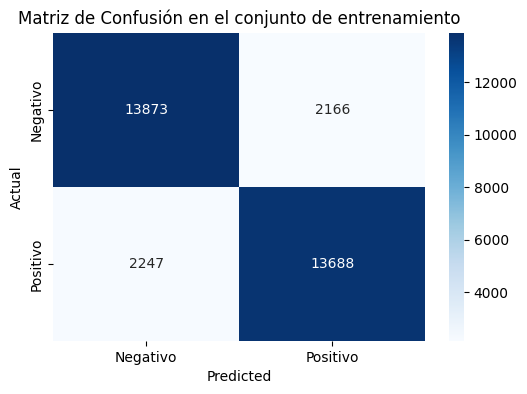

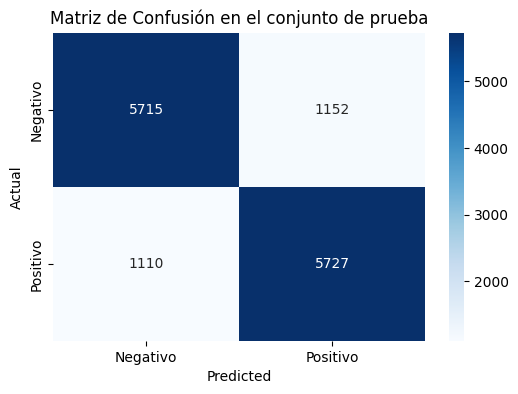

In [57]:
mostrar_matriz_confusion(best_naive_bayes, X_train, y_train, X_test, y_test)

Guardamos el modelo en un archivo .pkl y luego lo cargamos para hacer uso del mismo

In [58]:
with open('modelo_naive_bayes.pkl', 'wb') as file:
    pickle.dump(best_naive_bayes, file)

with open('modelo_naive_bayes.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Realizamos las predicciones en el conjunto test_data, realizando el mapeo correspondiente para que vuelva a ser sentimiento positivo y negativo

In [59]:
y_test_data_pred = loaded_model.predict(X_test_data)
y_test_data_pred = np.where(y_test_data_pred == 0, 'negativo', 'positivo')

Obtenemos un dataframe con las predicciones con la estructura pedida en la consigna y lo descargamos para subirlo a la competencia de Kaggle

In [60]:
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'sentimiento': y_test_data_pred})
predictions_df.to_csv('predicciones_bn_final.csv', index=False)